In [1]:
#set up the environment
import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiSpheresMasker
import time
import sys

# parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = sub_info['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
task = 'loc'

all_data = []

for sub in subs:
    for roi in rois:
        for hemi in hemispheres:
            file_path = f'{study_dir}/{sub}/ses-01/derivatives/roi_activations/{sub}_{roi}_{hemi}_{task}_roi_activation.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                mean_activation = df['mean_activation'].mean()
                all_data.append({
                    'subject': sub,
                    'roi': roi,
                    'hemisphere': hemi,
                    'mean_activation': mean_activation
                })

results_df = pd.DataFrame(all_data)

# Calculate group averages
group_averages = results_df.groupby(['roi', 'hemisphere'])['mean_activation'].mean().reset_index()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
chart_data = []
for roi in rois:
    roi_data = {'roi': roi}
    for hemi in hemispheres:
        value = group_averages[(group_averages['roi'] == roi) & (group_averages['hemisphere'] == hemi)]['mean_activation'].values[0]
        roi_data[hemi] = value
    chart_data.append(roi_data)

print(chart_data)

[{'roi': 'pIPS', 'left': 10674.061263157893, 'right': 10216.69382982456}, {'roi': 'LO', 'left': 10772.343684210526, 'right': 10478.117524561403}]


  Hemisphere   ROI Condition      Mean       Std  Count        SE      Region  \
0       Left    LO    object  6.163655  1.283674     19  0.294495     Left LO   
1       Left    LO  scramble  3.687608  0.715443     18  0.168631     Left LO   
2       Left  pIPS    object  4.300696  0.786301     19  0.180390   Left pIPS   
3       Left  pIPS  scramble  3.419512  0.615809     19  0.141276   Left pIPS   
4      Right    LO    object  5.674257  1.148859     19  0.263566    Right LO   
5      Right    LO  scramble  3.465632  0.626112     18  0.147576    Right LO   
6      Right  pIPS    object  4.091584  0.630835     19  0.144723  Right pIPS   
7      Right  pIPS  scramble  3.504176  0.554587     19  0.127231  Right pIPS   

  Region_order  
0      Left LO  
1      Left LO  
2    Left pIPS  
3    Left pIPS  
4     Right LO  
5     Right LO  
6   Right pIPS  
7   Right pIPS  


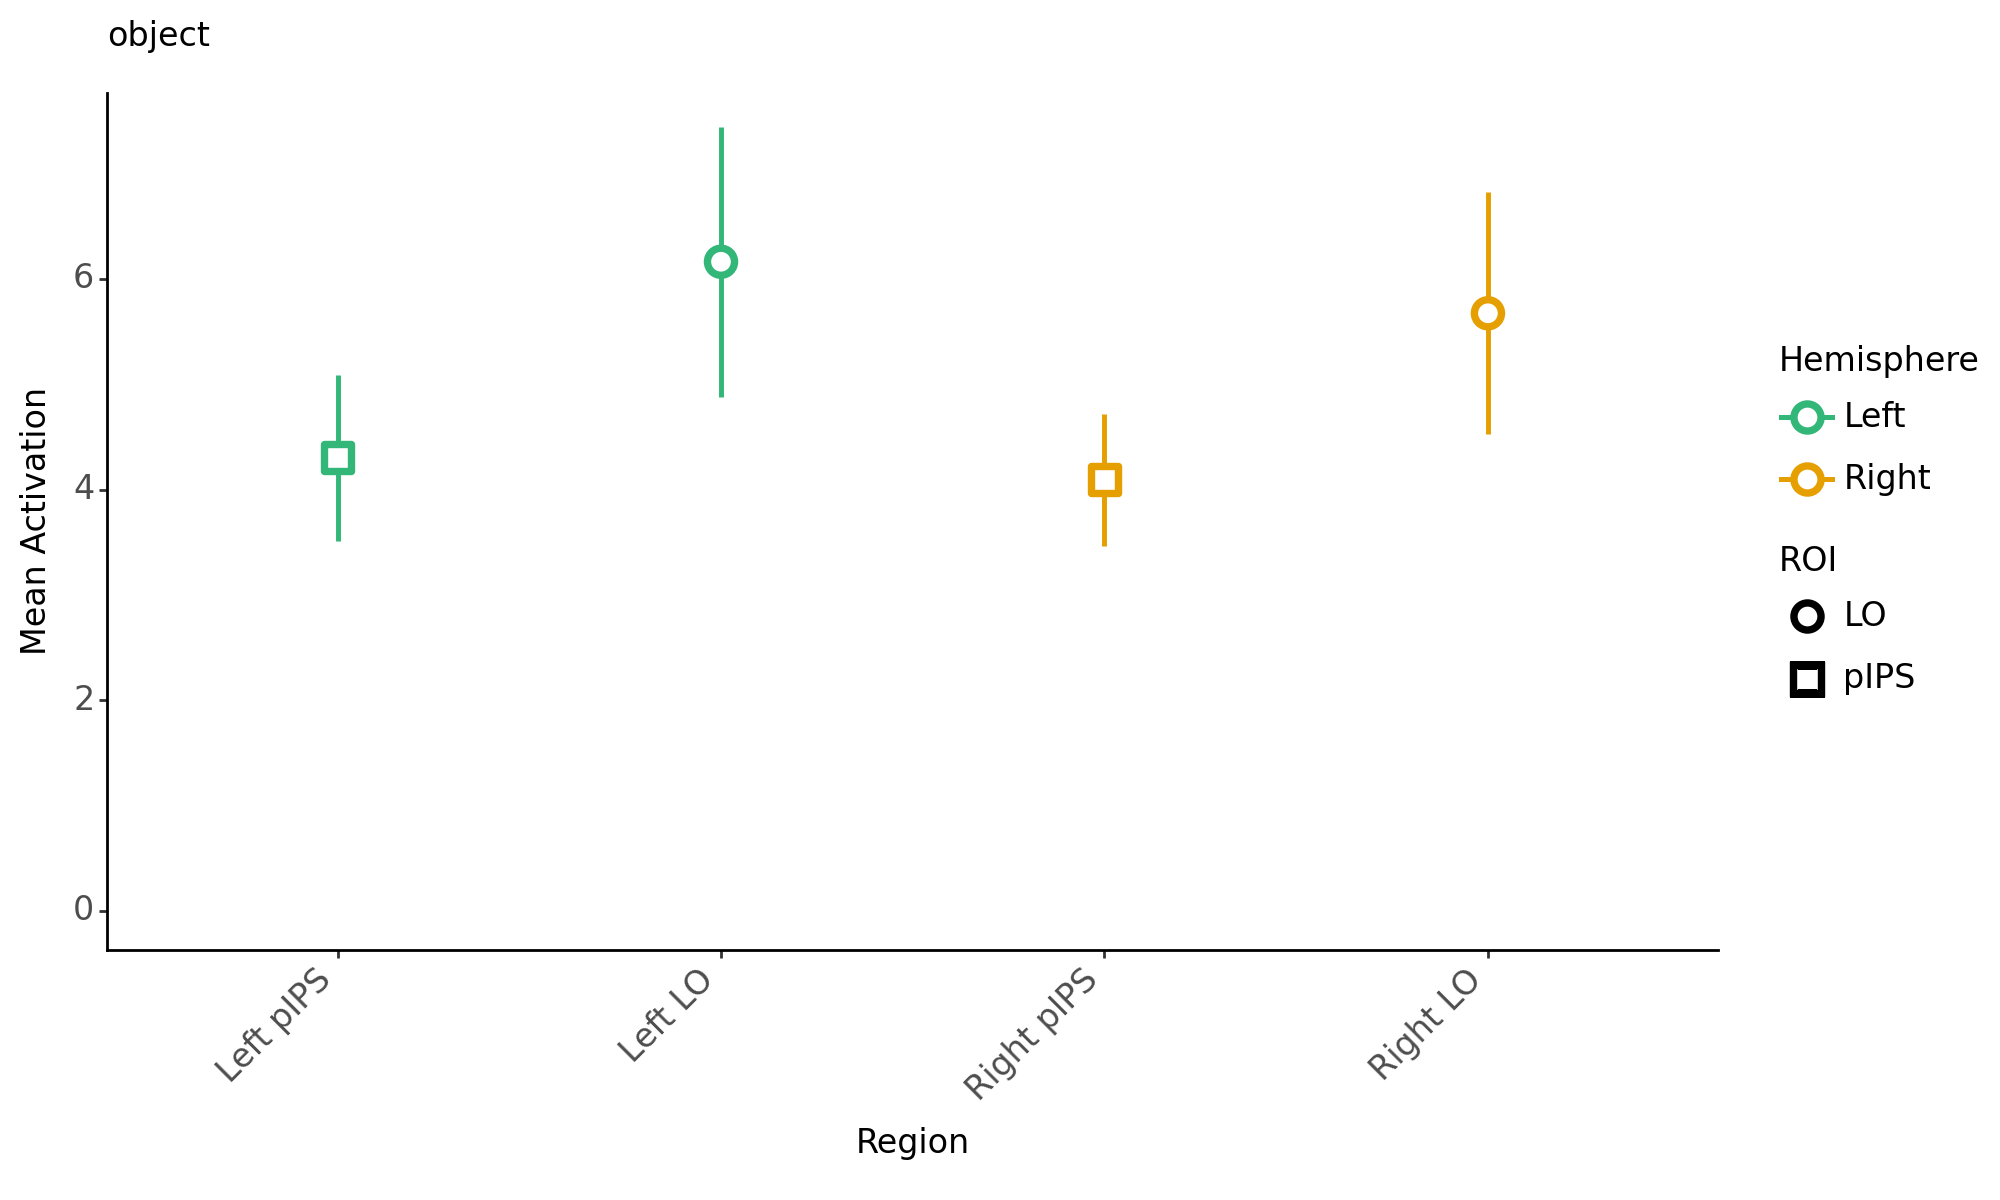

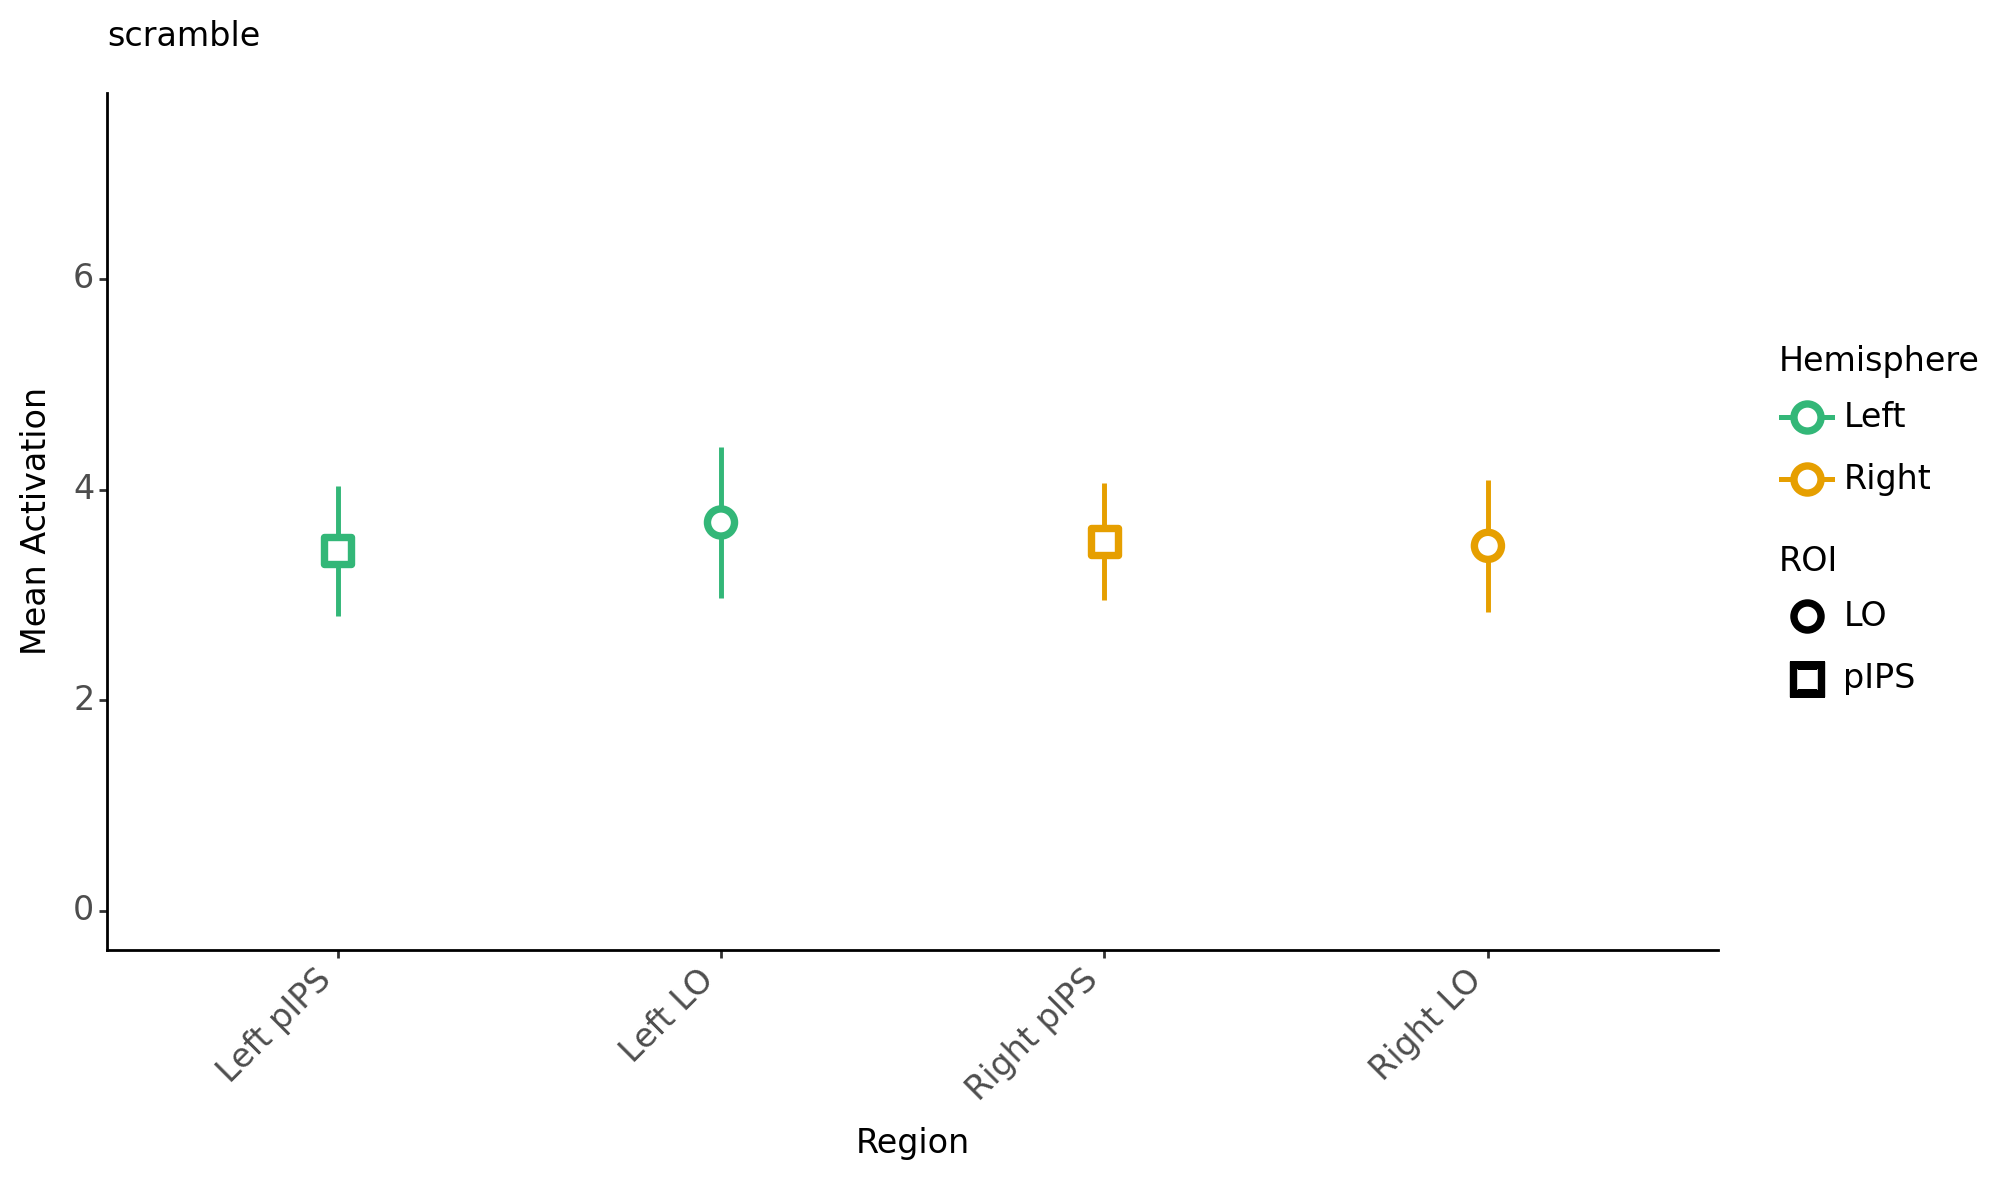

In [21]:
#roi raw activation from selectivity_summary file
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, labs,
                      scale_color_manual, scale_shape_manual, theme, element_text, element_line, element_blank,
                      coord_cartesian, scale_x_discrete, guides, guide_legend)

# Read the CSV data
data = pd.read_csv("results/selectivity/selectivity_summary.csv")

# Filter data for controls and relevant ROIs
filtered_data = data[(data['group'] == 'control') & 
                     (data['roi'].isin(['LO', 'pIPS'])) & 
                     (data['hemi'].isin(['left', 'right']))]

# Calculate mean activation and standard deviation for each combination
summary_df = filtered_data.groupby(['hemi', 'roi', 'cond'])['mean_act'].agg(['mean', 'std', 'count']).reset_index()
summary_df['sem'] = summary_df['std'] / np.sqrt(summary_df['count'])

# Rename columns for clarity
summary_df.columns = ['Hemisphere', 'ROI', 'Condition', 'Mean', 'Std', 'Count', 'SE']

# Create more readable labels
summary_df['ROI'] = summary_df['ROI'].map({'LO': 'LO', 'pIPS': 'pIPS'})
summary_df['Hemisphere'] = summary_df['Hemisphere'].map({'left': 'Left', 'right': 'Right'})
summary_df['Region'] = summary_df['Hemisphere'] + ' ' + summary_df['ROI']

# Create a custom order for the x-axis
summary_df['Region_order'] = pd.Categorical(summary_df['Region'], 
                                            categories=['Left pIPS', 'Left LO', 'Right pIPS', 'Right LO'],
                                            ordered=True)

# Print summary statistics
print(summary_df)

# Function to create plot for a specific condition
def create_plot(data, condition):
    plot = (ggplot(data[data['Condition'] == condition],
                   aes(x='Region_order', y='Mean', color='Hemisphere', shape='ROI'))
            + geom_linerange(aes(ymin='Mean-Std', ymax='Mean+Std'), size=1)
            + geom_point(size=4, fill='white', stroke=1.5)
            + theme_classic()
            + labs(title=f'{condition}',
                   x='Region', y='Mean Activation')
            + scale_color_manual(values={'Left': '#33B778', 'Right': '#E69F00'})
            + scale_shape_manual(values={'LO': 'o', 'pIPS': 's'})
            + theme(text=element_text(size=12),
                    axis_text_x=element_text(angle=45, hjust=1),
                    axis_line=element_line(colour="black"),
                    panel_border=element_blank(),
                    legend_position="right",
                    legend_box_margin=0,
                    figure_size=(10, 6))
            + coord_cartesian(ylim=(0, data['Mean'].max() * 1.2))
            + scale_x_discrete(limits=['Left pIPS', 'Left LO', 'Right pIPS', 'Right LO'])
            + guides(color=guide_legend(title="Hemisphere"),
                     shape=guide_legend(title="ROI")))
    return plot

# Create and print plots
object_plot = create_plot(summary_df, 'object')
scramble_plot = create_plot(summary_df, 'scramble')

print(object_plot)
print(scramble_plot)


# Save the plots
#object_plot.save("activation_plot_object.png", dpi=300, width=8, height=6)
#scramble_plot.save("activation_plot_scramble.png", dpi=300, width=8, height=6)

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


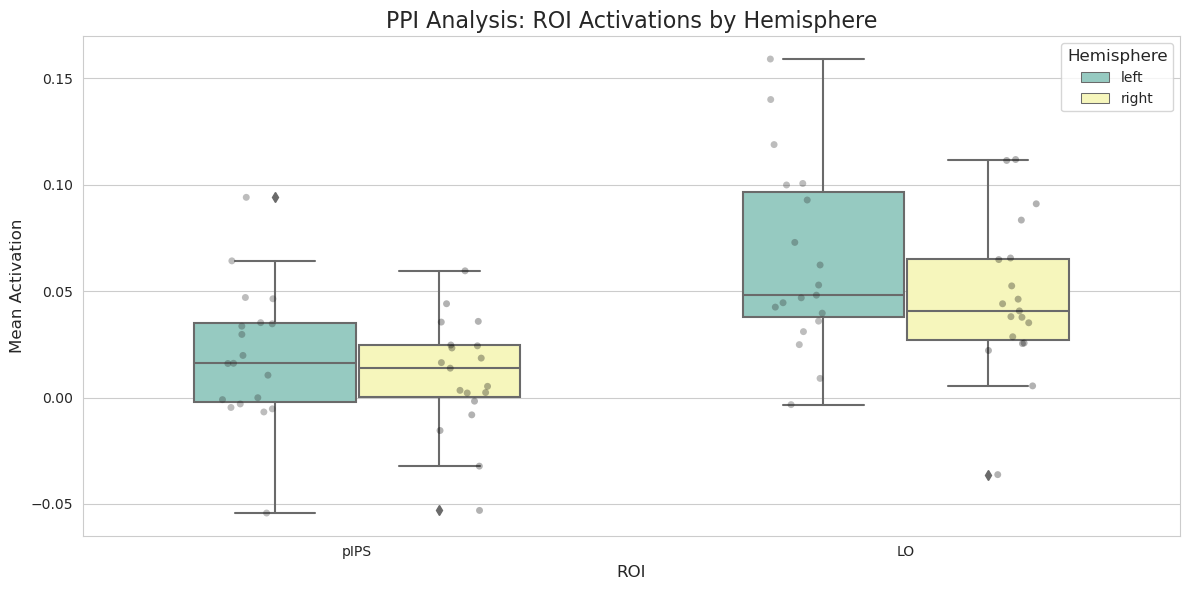

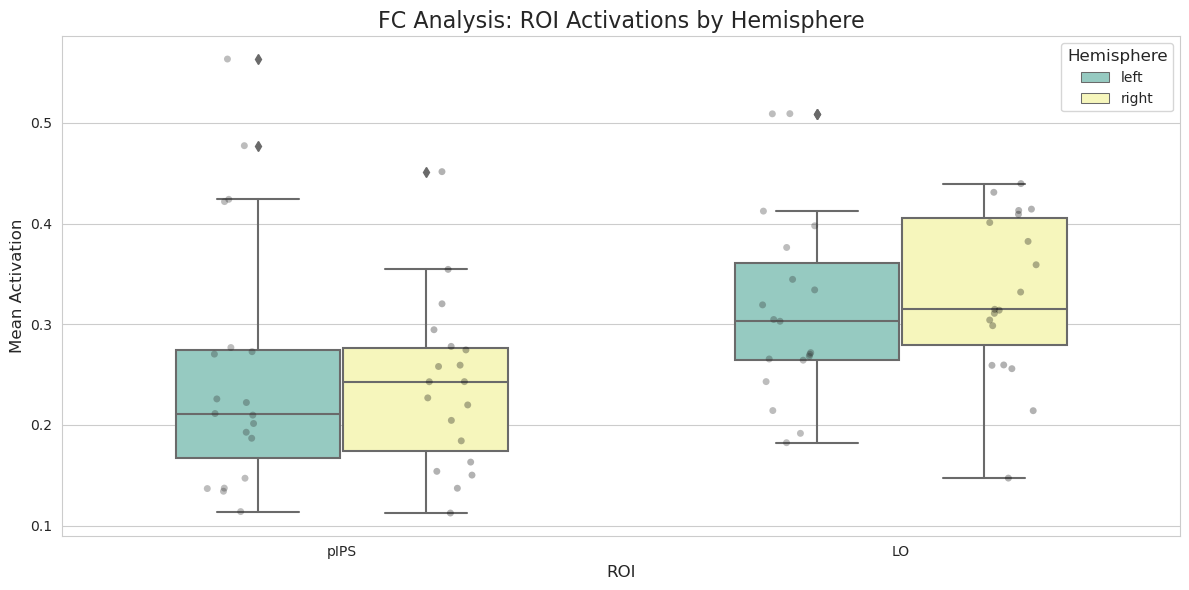

In [11]:
#roi activations by hemisphere and analysis type - ppi and fc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Create the box plot
    sns.boxplot(x='roi', y='mean_activation', hue='hemisphere', 
                data=data[data['analysis'] == analysis_type],
                palette='Set3', width=0.6)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('ROI', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    plt.legend(title='Hemisphere', title_fontsize='12', fontsize='10')
    
    # Add individual data points
    sns.stripplot(x='roi', y='mean_activation', hue='hemisphere', 
                  data=data[data['analysis'] == analysis_type],
                  dodge=True, alpha=0.3, color='black')
    
    # Remove legend for stripplot
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Hemisphere', title_fontsize='12', fontsize='10')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    #plt.savefig(output_path, dpi=300)
    #plt.close()

# Generate plots for both PPI and FC analyses
create_boxplot(data, 'ppi')
create_boxplot(data, 'fc')

print(f"Plots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")

In [16]:
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                      ylim, xlab, ylab, ggtitle, theme, element_text, element_line, 
                      element_blank, scale_color_manual, position_dodge2, 
                      geom_hline, scale_shape_manual, labs, facet_wrap)
import os
from scipy import stats

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

def create_plot(data, analysis_type):
    # Create a new column combining hemisphere and ROI
    data['region'] = data['hemisphere'] + data['roi']
    
    # Create summary dataframe
    summary_df = data[data['analysis'] == analysis_type].groupby('region').agg({
        'mean_activation': ['mean', 'sem']
    }).reset_index()
    summary_df.columns = ['region', 'mean', 'se']

    # Ensure consistent ordering
    region_order = ['leftpIPS', 'leftLO', 'rightpIPS', 'rightLO']
    summary_df['region'] = pd.Categorical(summary_df['region'], categories=region_order, ordered=True)
    summary_df = summary_df.sort_values('region')

    # Set appropriate y-axis label
    if analysis_type == 'fc':
        y_label = 'Functional Connectivity'
        title = 'FC Analysis: ROI Functional Connectivity'
    elif analysis_type == 'ppi':
        y_label = 'PPI Connectivity'
        title = 'PPI Analysis: ROI Connectivity with Psychological Regressor'

    # Create the plot
    plot = (ggplot(summary_df, aes(x='region', y='mean', color='region', shape='region'))
            + geom_linerange(aes(ymin='mean - se', ymax='mean + se'), 
                             size=1, position=position_dodge2(width=0.5))
            + geom_point(size=4, fill='white', stroke=1, 
                         position=position_dodge2(width=0.5))
            + scale_color_manual(values=['#31688E', '#440154', '#31688E', '#440154'])
            + scale_shape_manual(values=['o', 's', 'o', 's'])
            + theme_classic()
            + labs(color='Region', shape='Region')
            + xlab('Region')
            + ylab(y_label)
            + ggtitle(title)
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=45, hjust=1, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                plot_title=element_text(size=16),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(10, 6)
            ))

    # Save the plot
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_connectivity.png')
    plot.save(output_path, dpi=300, bbox_inches='tight')
    print(f"{analysis_type.upper()} plot has been saved as: {output_path}")

    # Perform statistical tests
    stats_results = []
    for roi in ['pIPS', 'LO']:
        left_data = data[(data['analysis'] == analysis_type) & (data['roi'] == roi) & (data['hemisphere'] == 'left')]['mean_activation']
        right_data = data[(data['analysis'] == analysis_type) & (data['roi'] == roi) & (data['hemisphere'] == 'right')]['mean_activation']
        t_stat, p_val = stats.ttest_rel(left_data, right_data)
        effect_size = (left_data.mean() - right_data.mean()) / np.sqrt((left_data.var() + right_data.var()) / 2)
        stats_results.append({
            'analysis': analysis_type,
            'roi': roi,
            'mean_diff': left_data.mean() - right_data.mean(),
            't_stat': t_stat,
            'p_value': p_val,
            'effect_size': effect_size
        })

    # Create and save summary table
    summary_table = pd.DataFrame(stats_results)
    summary_table_path = os.path.join(results_dir, f'{analysis_type}_summary_stats.csv')
    summary_table.to_csv(summary_table_path, index=False)
    print(f"{analysis_type.upper()} summary statistics have been saved to: {summary_table_path}")

# Generate plots for both PPI and FC analyses
create_plot(data, 'ppi')
create_plot(data, 'fc')

print(f"All plots and summary statistics have been saved in the directory: {results_dir}")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_roi_connectivity.png


PPI plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_roi_connectivity.png
PPI summary statistics have been saved to: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_summary_stats.csv


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_roi_connectivity.png


FC plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_roi_connectivity.png
FC summary statistics have been saved to: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_summary_stats.csv
All plots and summary statistics have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis


/tmp/ipykernel_33395/2207715975.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_33395/2207715975.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_33395/2207715975.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


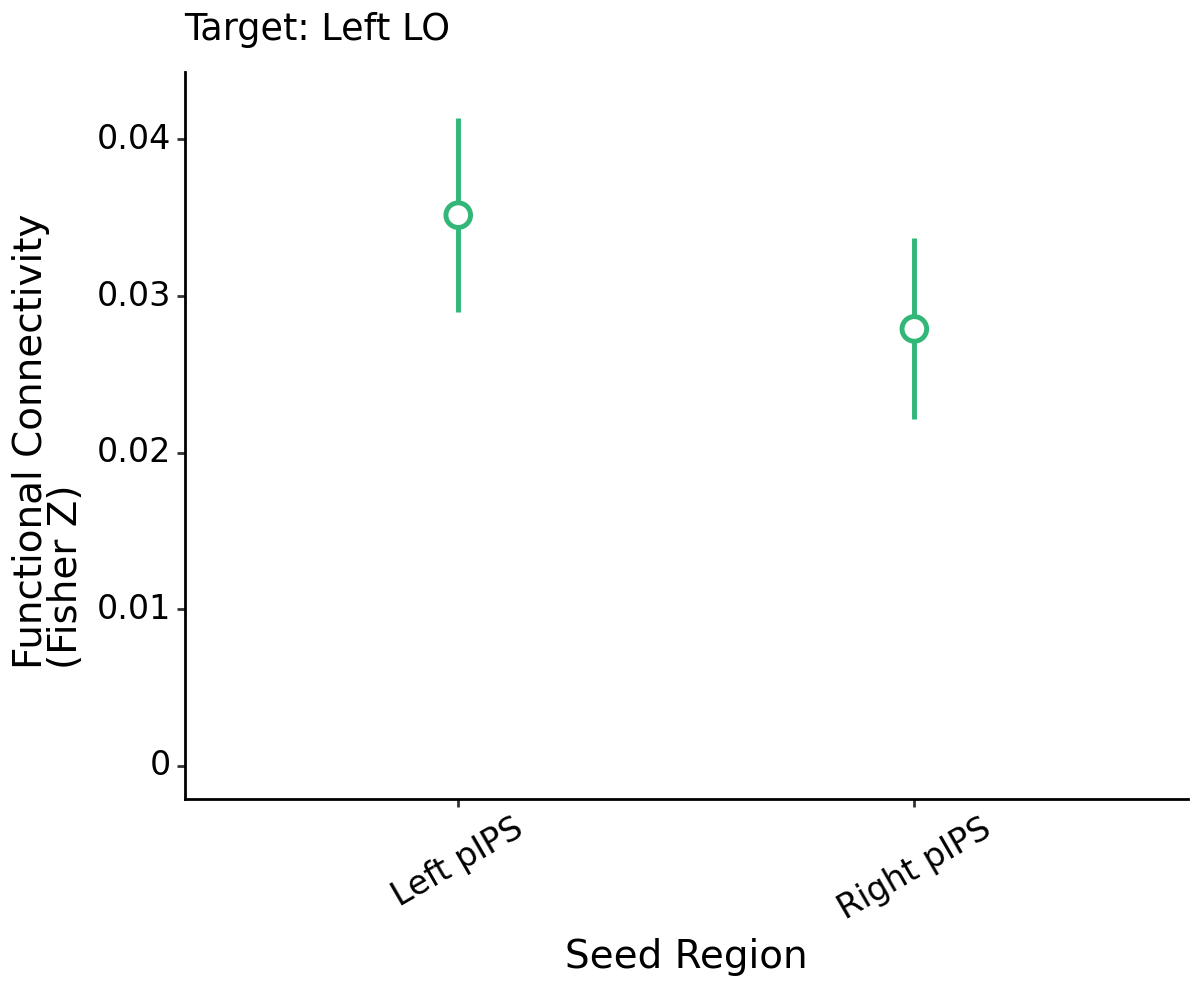

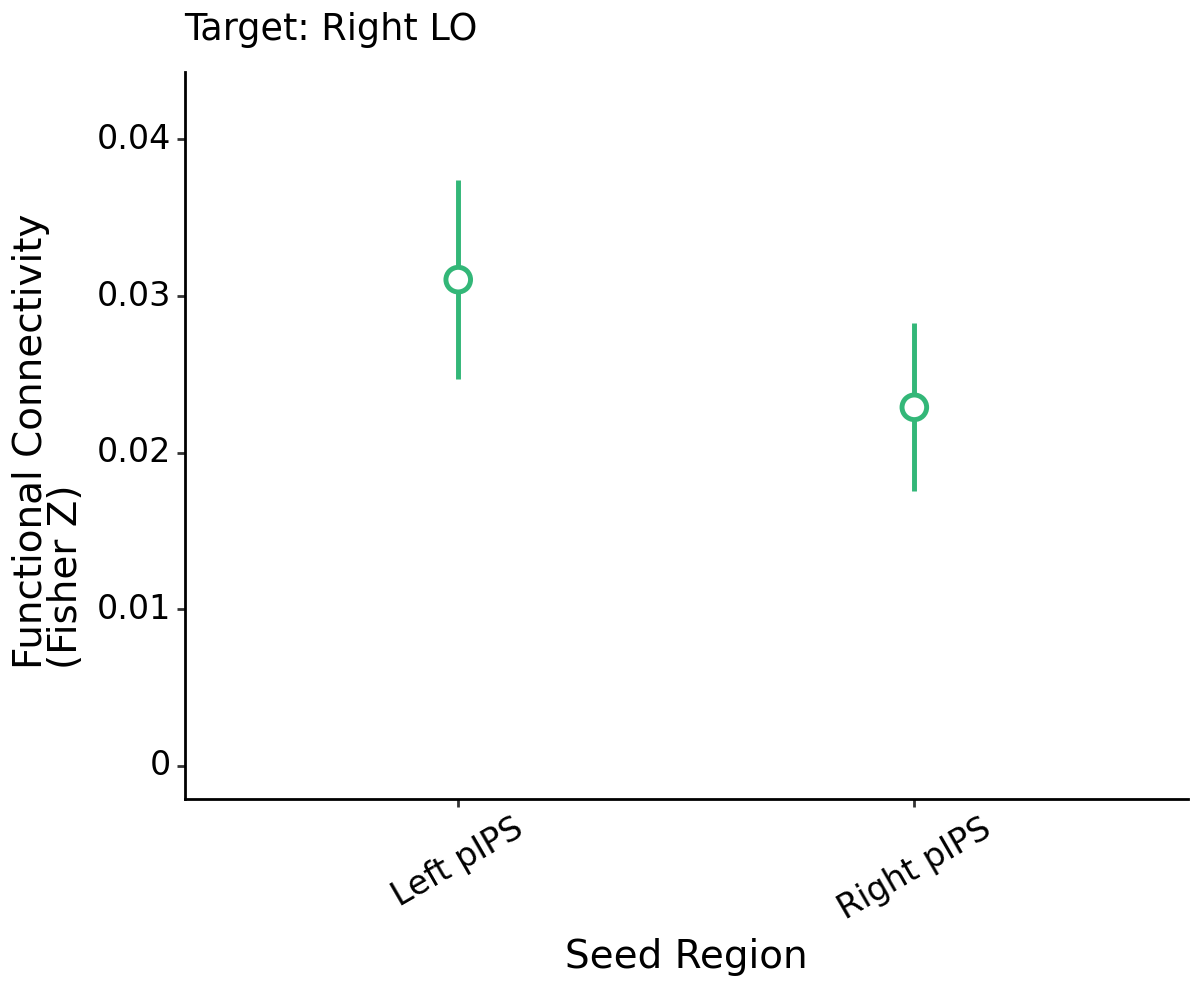

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: left_lo_ppi_plot.png
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: right_lo_ppi_plot.png


In [3]:
#corrected to seed to target see - matchvlad_seed_target_activations.csv
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, scale_color_manual, theme, element_text, element_line, element_blank, facet_wrap, ggtitle

# Define variables
analysis = 'ppi'#'fc'
#analysis = 'fc'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'ppi')]
#df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'fc')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Function to create plot for a specific target
def create_plot(data, target):
    plot = (ggplot(data[data['Target'] == target], aes(x='Seed', y='FC', color='LOC'))
            + geom_linerange(aes(ymax='FC + SE', ymin='FC - SE'), size=1)
            + geom_point(shape='o', size=4, fill='white', stroke=1)
            + ylim(0, data['FC'].max() * 1.2)  # Adjust ylim based on data
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity \n(Fisher Z)')
            + scale_color_manual(values=['#33B778'])
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
left_lo_plot = create_plot(summary_df, 'Left LO')
right_lo_plot = create_plot(summary_df, 'Right LO')

print(left_lo_plot)
print(right_lo_plot)

# Optionally, save the plots
left_lo_plot.save("left_lo_ppi_plot.png", dpi=300)
right_lo_plot.save("right_lo_ppi_plot.png", dpi=300)